In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch
import torch.nn as nn

import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime   
from torch.utils.data import Dataset, DataLoader
import os
from scipy import io, signal
import math
import random
import h5py
from tqdm import tqdm
from IPython.display import clear_output
import import_ipynb

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
from module.data_simulation import MotionParameters, SimulatedDataset

image_path = "./Data/Uncombined_data1/"
sens_path = "./Data/sensitivity1/"
init_rot = 10 
motion_ran_lb = [0,0,0] #(offset, x-dif, y-dif)
motion_ran_ub = [0.5,0.5,0.5]
motion_PE_ran = [56, 224-56]
SNR_ran = [100,200]
img_size = [224, 224]
# batch_size = 100 -> unused
epochs = 500

params = MotionParameters(img_size, SNR_ran, motion_ran_lb, motion_ran_ub, motion_PE_ran, rot=init_rot)
train_ds = SimulatedDataset(image_path, sens_path, params, split='train', multiple=epochs)
test_ds = SimulatedDataset(image_path, sens_path, params, split='test', multiple=10)

4500
complex128


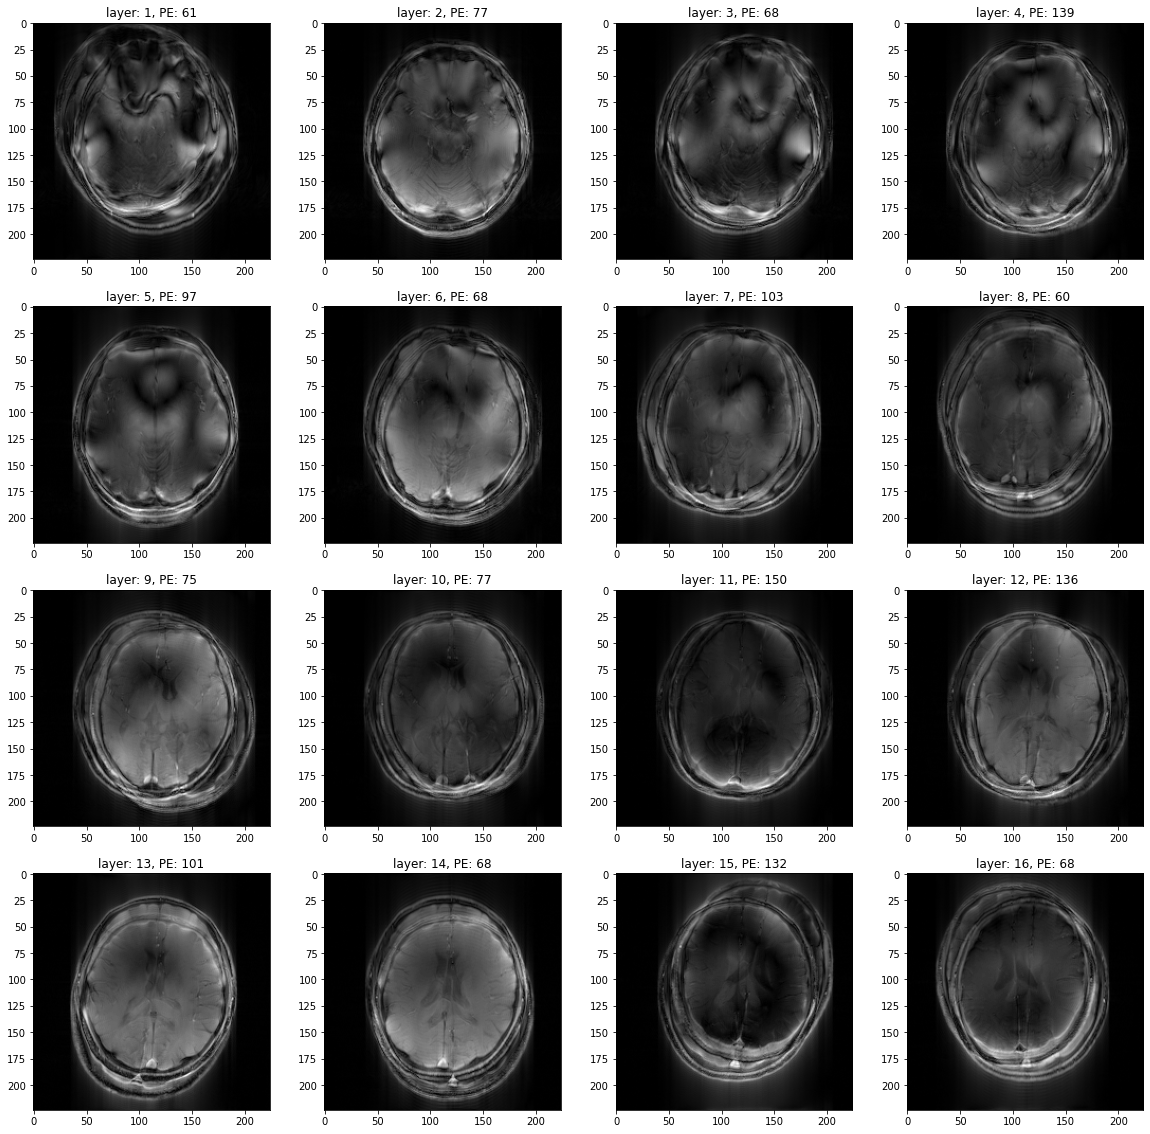

In [10]:
corrupted, PE = train_ds[24]

fig, axes = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(20)
layer = 0
for axes_x in axes:
    for axis in axes_x:
        axis.imshow(abs(np.fft.ifftn(corrupted[:,:,layer], axes=(0,1))), cmap="gray")
        # axis.imshow(abs(np.fft.fftshift(corrupted[:,:,layer])), cmap="gray", vmin=0, vmax=1e-3)
        axis.set_title(f"layer: {layer + 1}, PE: {PE[layer]}")
        layer = layer + 1
    
print(len(train_ds))
print(corrupted.dtype)

In [ ]:
save_path = "./Data/h5/train2"
epoch_size = len(train_ds) // epochs
data_cnt = 0
start_epoch = 50

os.makedirs(save_path, exist_ok=True)
for epoch in tqdm(range(start_epoch, epochs)):
    # clear_output()
    # print(f"Epoch {epoch + 1} / {epochs}...")
    h5file_path = save_path + "/" + str(epoch) + ".h5"
    with h5py.File(h5file_path, "w") as f: # each epoch
        group_no = 0
        for data_no in range(epoch_size):  # number of the data in each epoch
            brain, label = train_ds[data_no] # multi-layer, motion-corrupted dicom in k-space. (224, 224, 16)
            for layer in range(brain.shape[-1]):
                group = f.create_group(str(group_no))
                group.create_dataset("image", data=brain[:,:,layer], dtype=np.complex128)
                group.create_dataset("label", data=label[layer], dtype=int)
                group_no = group_no + 1

 32%|███████████▊                         | 144/450 [3:14:06<6:53:23, 81.06s/it]

In [79]:
save_path = "./Data/h5/test2"
epoch_size = len(test_ds)
data_cnt = 0

os.makedirs(save_path, exist_ok=True)
for epoch in range(0, 1):
    h5file_path = save_path + "/" + str(epoch) + ".h5"
    with h5py.File(h5file_path, "w") as f:
        group_no = 0
        for data_no in tqdm(range(epoch_size)):  # number of the data in each epoch
            brain, label = test_ds[data_no] # multi-layer, motion-corrupted dicom in k-space. (224, 224, 16)
            for layer in range(brain.shape[-1]):
                group = f.create_group(str(group_no))
                group.create_dataset("image", data=brain[:,:,layer], dtype=np.complex128)
                group.create_dataset("label", data=label[layer], dtype=int)
                group_no = group_no + 1

100%|███████████████████████████████████████████| 10/10 [01:26<00:00,  8.69s/it]
